# PCA Analysis Using rdkit

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import json
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import pandas as pd

from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

In [3]:
def read_json(path):
    with open(path, 'r') as infile:
        dat = json.load(infile)
    return dat

def save_json(d, path, indent=4, sort_keys=True):
    """Saves a json file to the path specified.

    Parameters
    ----------
    d : dict
        Must be serializable.
    path : str
        File path to save at.
    """

    with open(path, 'w') as outfile:
        json.dump(d, outfile, indent=indent, sort_keys=sort_keys)

In [4]:
class NullClass:
    def do_nothing(*args, **kwargs):
        pass
    def add_colorbar(self, im, **kwargs):
        return plt.colorbar(im)
    def __getattr__(self, _):
        return self.do_nothing
try:
    from mpl_utils import MPLAdjutant
    adj = MPLAdjutant()
    adj.set_defaults()
except ImportError:
    adj = NullClass()

## Nitrogen Database

#### Load Nitrogen Data

In [5]:
import os
os.chdir('../..')
from gale.ml import Data
import rdkit

In [6]:
data = pickle.load(open("/Users/aghose/Desktop/BNL2022/Data/22_QM9_forward/XANES-220622-ACSF-N.pkl", "rb"))

In [7]:
from matplotlib import cm

grid = data['grid']
acsf_array = data['x']
spectra = data['y']

#### Nitrogen PCA Plot

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pca_acsf = PCA(2)
w_acsf = pca_acsf.fit_transform(acsf_array)

pca_spectra = PCA(2)
w_spectra = pca_spectra.fit_transform(spectra)

N = 10
M = 100

dig = np.digitize(w_acsf[::N, 0], bins=np.linspace(w_acsf[::N, 0].min(), w_acsf[::N, 0].max(), M))

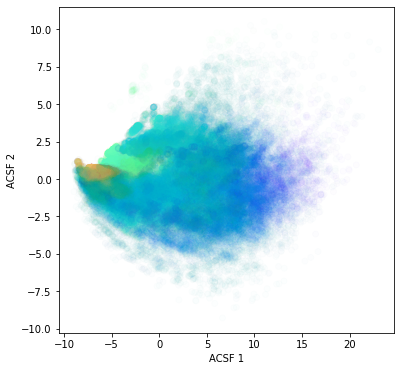

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha = 0.01, c = w_spectra[:, 0], cmap = "rainbow")

ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
# plt.savefig('N_PCA.svg')
plt.show()

#### Cluster 1 (Orange)

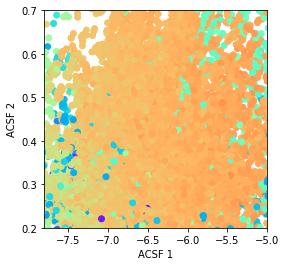

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha = 1.0, c = w_spectra[:, 0], cmap = "rainbow")

ax.set_xlim(-7.8,-5)
ax.set_ylim(0.2,0.7)
ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
plt.show()

In [11]:
#Gathering points in region visually
indices = []
for i in range(len(w_acsf)):
    x,y = w_acsf[i]
    if -7.8<x<-5 and 0.2<y<0.7:
        indices.append(i)

In [12]:
orange = w_spectra[:,0][indices]
o_mean = np.mean(orange)
o_std = np.std(orange)

#spectra stats
print(o_mean, o_std)

8.928883372863178 2.483955962805071


In [13]:
#Getting points one std from mean spectra color
o_indices = []
for i in indices:
    if o_mean - o_std < w_spectra[:,0][i] < o_mean + o_std:
        o_indices.append(i)

#### Cluster 2 (Green)

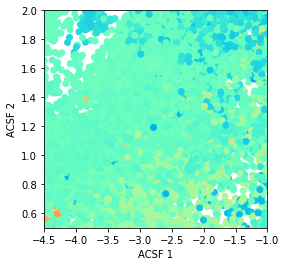

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha = 1, c = w_spectra[:, 0], cmap = "rainbow")

ax.set_xlim(-4.5,-1)
ax.set_ylim(0.5,2)
ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
plt.show()

In [15]:
#Gathering points in region visually
indices = []
for i in range(len(w_acsf)):
    x,y = w_acsf[i]
    if -4.5<x<-1 and 0.5<y<2:
        indices.append(i)

In [16]:
green = w_spectra[:,0][indices]
g_mean = np.mean(green)
g_std = np.std(green)

#spectra stats
print(g_mean, g_std)

1.8554509152793663 1.6434158659796403


In [17]:
#Getting points one std from mean spectra color
g_indices = []
for i in indices:
    if g_mean - g_std < w_spectra[:,0][i] < g_mean + g_std:
        g_indices.append(i)

#### Load Nitrogen SMILES Data

In [18]:
SMILES = data['origin_smiles']
SMILES = np.array(SMILES)

In [19]:
#SMILES of selected points
o_smiles = SMILES[o_indices]
g_smiles = SMILES[g_indices]


#### Descriptor Information

In [20]:
import rdkit
from rdkit import Chem
import rdkit.Chem.Descriptors as Des

In [21]:
#Convert SMILES to Mols
o_ms = [Chem.MolFromSmiles(smi) for smi in o_smiles]
g_ms = [Chem.MolFromSmiles(smi) for smi in g_smiles]

In [22]:
def printDescription(groupName, molList):
    """Prints out descriptor information about molecules in a list.

    Parameters
    ----------
    molList : list
        List of molecules.
    """
    
    numAtoms = [mol.GetNumAtoms() for mol in molList]
    numBonds = [mol.GetNumBonds() for mol in molList]
    molWts = [Des.ExactMolWt(mol) for mol in molList]
    NumValEl = [Des.NumValenceElectrons(mol) for mol in molList]
    molDen = [Des.FpDensityMorgan1(mol) for mol in molList]
    
    print("                      ------{} Group------\n".format(groupName))
    print("                     Mean                 SD")
    print('NumAtoms            = {:>.5}            {:>.5}'.format(np.mean(numAtoms), np.std(numAtoms)))
    print('NumBonds            = {:>.5}            {:>.5}'.format(np.mean(numBonds), np.std(numBonds)))
    print('Mol. Weight         = {:>.5}            {:>.5}'.format(np.mean(molWts), np.std(molWts)))
    print('Num. Val. Electrons = {:>.5}            {:>.5}'.format(np.mean(NumValEl), np.std(NumValEl)))
    print('Mol. Density        = {:>.5}            {:>.5}'.format(np.mean(molDen), np.std(molDen)))


In [23]:
printDescription("Orange", o_ms)
printDescription("Green", g_ms)

                      ------Orange Group------

                     Mean                 SD
NumAtoms            = 8.7834            0.51255
NumBonds            = 8.9307            0.99128
Mol. Weight         = 120.88            7.45
Num. Val. Electrons = 46.716            3.2937
Mol. Density        = 1.7431            0.18037
                      ------Green Group------

                     Mean                 SD
NumAtoms            = 8.8247            0.44973
NumBonds            = 9.0902            0.91694
Mol. Weight         = 123.67            6.5846
Num. Val. Electrons = 47.86            2.8967
Mol. Density        = 1.7365            0.17267


In [24]:
#Get mol names to get absorbing atom index
names = data['names']
names = np.array(names)
o_names = names[o_indices]
g_names = names[g_indices]

In [25]:
#Gets Absorbing Atom Index from molecule name
def getIndex(name):
    return int(name.split('_',1)[1])


In [26]:
#Add Hydrogen toms to the Mols
o_ms_H = [Chem.AddHs(mol) for mol in o_ms]
g_ms_H = [Chem.AddHs(mol) for mol in g_ms]

#Make list of absorbing atoms
o_abs_atom = [o_ms_H[i].GetAtomWithIdx(getIndex(o_names[i])) for i in range(len(o_ms_H))]
g_abs_atom = [g_ms_H[i].GetAtomWithIdx(getIndex(g_names[i])) for i in range(len(g_ms_H))]

In [27]:
def GetNeighborList(atomList):
    """Creates a list of the sets of neighbors of each atom in a list of atoms.

    Parameters
    ----------
    atomList : list
        Must be a list of rdkit Atoms.
    """
    
    nborList = []
    for atom in atomList:
        nbors = atom.GetNeighbors()
        nborList.append(nbors)
    return nborList


def GetNeighborsCnt(atomList):
    """Creates a dictionary with list of neighbors of each atom in a list of atoms and how many times the neighbors 
    occur in that list.

    Parameters
    ----------
    atomList : list
        Must be a list of rdkit Atoms.
    """
    
    nbors = {}
    for atom in atomList:
        nList = []
        for n in atom.GetNeighbors():
            nList.append(n.GetSymbol())
        
        if nbors.get(str(nList)) == None:
            nbors.update({str(nList):1})
        else:
            nbors[str(nList)] += 1
    return nbors

def GetLocDesc(groupName, atomList):
    """Prints out list of neighbhors of each absorbing atom and how many times that set of neighbors occurs (count) along with 
    percentage of total molecules in region that have those neighbors. The total number of molecules looked at is also printed.

    Parameters
    ----------
    groupName : str
        Name of group of molecules/atoms.
    atomList : list
        Must be a list of rdkit Atoms.
    """
    
    nborCount = GetNeighborsCnt(atomList)
    total = len(atomList)
    sort_nborCount = sorted(nborCount.items(), key=lambda x: x[1], reverse=True)
    
    print("                      ------{} Group------".format(groupName))
    print("\nTotal: ", total)
    print("\nNeighbor Count \n(Neighbors of Absorbing Atom : Count / (Percentage)): \n")
    
    for nbors, count in sort_nborCount:
        print(nbors, ": ", count, " / ({} %)".format(round((count/total)*100, 4)))
    

In [28]:
GetLocDesc("Orange", o_abs_atom)
GetLocDesc("Green", g_abs_atom)


                      ------Orange Group------

Total:  11782

Neighbor Count 
(Neighbors of Absorbing Atom : Count / (Percentage)): 

['C'] :  11568  / (98.1837 %)
['N', 'O'] :  62  / (0.5262 %)
['C', 'O'] :  55  / (0.4668 %)
['O', 'N'] :  53  / (0.4498 %)
['N'] :  36  / (0.3056 %)
['C', 'N'] :  2  / (0.017 %)
['O', 'C'] :  2  / (0.017 %)
['C', 'H', 'H'] :  1  / (0.0085 %)
['C', 'N', 'N'] :  1  / (0.0085 %)
['C', 'O', 'C'] :  1  / (0.0085 %)
['C', 'O', 'N'] :  1  / (0.0085 %)
                      ------Green Group------

Total:  6764

Neighbor Count 
(Neighbors of Absorbing Atom : Count / (Percentage)): 

['C', 'H'] :  6406  / (94.7073 %)
['C', 'C'] :  247  / (3.6517 %)
['O', 'C'] :  35  / (0.5174 %)
['C', 'O'] :  33  / (0.4879 %)
['C', 'H', 'H'] :  24  / (0.3548 %)
['C', 'C', 'H'] :  6  / (0.0887 %)
['C'] :  4  / (0.0591 %)
['N'] :  4  / (0.0591 %)
['C', 'N', 'H'] :  2  / (0.0296 %)
['C', 'F', 'C'] :  1  / (0.0148 %)
['C', 'O', 'C'] :  1  / (0.0148 %)
['C', 'O', 'O'] :  1  / (0.0148

#### Drawing Molecules From Groups

In [29]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import rdkit.Chem.Descriptors as Des
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

In [30]:
def GetHighlight(molList, names, substructure):
    """Creates list of molecules with a specific substructure highlighted from original molecule list.

    Parameters
    ----------
    molList : list
        Non-highlighted original molecule list.
    names : list
        List of names of molecules including abs. atom index.
    substructure : rdkit.Chem.Mol
        rdkit substructure molecule
    """
    
    highlightList = []
    for i in range(len(molList)):
        h = []
        h.append(getIndex(names[i]))
        a = molList[i].GetSubstructMatches(substructure)
        if len(a) > 0:
            h = h + list(a[0])
        highlightList.append(h)
    return highlightList

def GetNeighborIdx(molList, names):
    """Gets atomic index of neighbhors of absorbing atoms.

    Parameters
    ----------
    molList : list
        List of rdkit molecules.
    names : list
        List of names of molecules including abs. atom index.
    """
    
    highlightList = []
    for i in range(len(molList)):
        idxs = []
        idx1 = getIndex(names[i])
        idxs.append(idx1)
        a = molList[i].GetAtomWithIdx(idx1)
        n = a.GetNeighbors()
        for atom in n:
            idxs.append(atom.GetIdx())
        highlightList.append(idxs)
    return highlightList

In [31]:
o_hl_list = GetNeighborIdx(o_ms_H, o_names)
g_hl_list = GetNeighborIdx(g_ms_H, g_names)


In [32]:
#Highlighting absorbing atoms neighbors
h_o_ms_H = o_ms_H
h_g_ms_H = g_ms_H

for i in range(len(o_ms_H)):
    h_o_ms_H[i].__sssAtoms = o_hl_list[i]

for i in range(len(g_ms_H)):
    h_g_ms_H[i].__sssAtoms = g_hl_list[i]
    

In [33]:
o_labels = [o_names[i] + " (Orange)" for i in range(len(o_names))]
g_labels = [g_names[i] + " (Green)" for i in range(len(g_names))]

In [34]:
img1 = Draw.MolsToGridImage(h_o_ms_H[:6], subImgSize=(250,250), highlightAtomLists=o_hl_list, useSVG = True, legends = o_labels[:6])
Draw.MolsToGridImage(h_o_ms_H[:6], subImgSize=(250,250), highlightAtomLists=o_hl_list, legends = o_labels[:6], returnPNG= True)

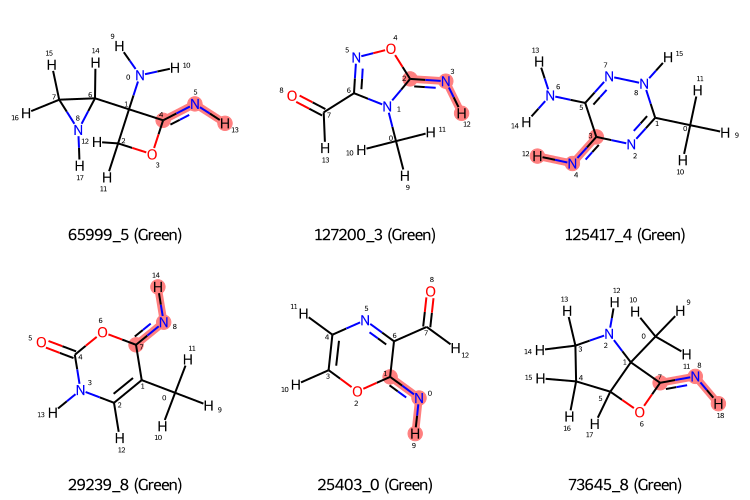

In [35]:
img2 = Draw.MolsToGridImage(h_g_ms_H[:6], subImgSize=(250,250), highlightAtomLists=g_hl_list, useSVG = True, legends = g_labels)
Draw.MolsToGridImage(h_g_ms_H[:6], subImgSize=(250,250), highlightAtomLists=g_hl_list,  legends = g_labels)

## Carbon Database

#### Load Carbon Data

In [36]:
data = pickle.load(open("/Users/aghose/Desktop/BNL2022/Data/22_QM9_forward/XANES-220622-ACSF-C.pkl", "rb"))

In [37]:
from matplotlib import cm

grid = data['grid']
acsf_array = data['x']
spectra = data['y']

#### Carbon PCA Plot

In [38]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pca_acsf = PCA(2)
w_acsf = pca_acsf.fit_transform(acsf_array)

pca_spectra = PCA(2)
w_spectra = pca_spectra.fit_transform(spectra)

# print(w_spectra.shape)
# print(w_acsf.shape)

N = 10
M = 100

dig = np.digitize(w_acsf[::N, 0], bins=np.linspace(w_acsf[::N, 0].min(), w_acsf[::N, 0].max(), M))
cmap = cm.get_cmap("rainbow", M)

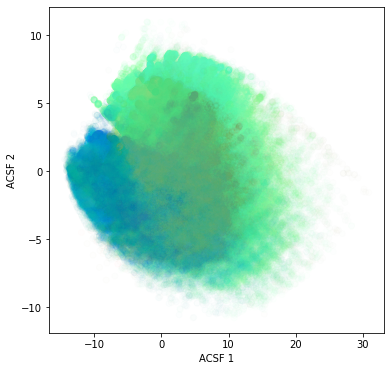

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha=0.01, c=w_spectra[:, 0], cmap="rainbow")

ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
# plt.savefig('C_PCA.svg')
plt.show()

#### Cluster 1 (Blue)

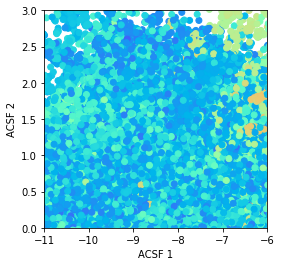

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha=1.0, c=w_spectra[:, 0], cmap="rainbow")

ax.set_xlim(-11,-6)
ax.set_ylim(0,3)
ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
plt.show()

In [41]:
#Gathering points in region visually
indices = []
for i in range(len(w_acsf)):
    x,y = w_acsf[i]
    if -11<x<-6 and 0<y<3:
        indices.append(i)

In [42]:
blue = w_spectra[:,0][indices]
b_mean = np.mean(blue)
b_std = np.std(blue)
#spectra stats
print(b_mean, b_std)

-4.386009700863419 3.357462998370511


In [43]:
#Getting points one std from mean spectra color
b_indices = []
for i in indices:
    if b_mean - b_std < w_spectra[:,0][i] < b_mean + b_std:
        b_indices.append(i)

#### Cluster 2 (Green)

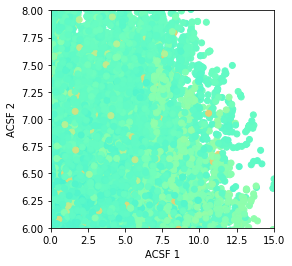

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha=1, c=w_spectra[:, 0], cmap="rainbow")

ax.set_xlim(0,15)
ax.set_ylim(6,8)
ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
plt.show()

In [45]:
#Gathering points in region visually
indices = []
for i in range(len(w_acsf)):
    x,y = w_acsf[i]
    if 0<x<15 and 6<y<8:
        indices.append(i)

In [46]:
green = w_spectra[:,0][indices]
g_mean = np.mean(green)
g_std = np.std(green)

#spectra stats
print(g_mean, g_std)

0.526055589582826 1.4324342149105282


In [47]:
#Getting points one std from mean spectra color
g_indices = []
for i in indices:
    if g_mean - g_std < w_spectra[:,0][i] < g_mean + g_std:
        g_indices.append(i)

#### Load Carbon SMILES Data

In [48]:
SMILES = data['origin_smiles']
SMILES = np.array(SMILES)

In [49]:
#SMILES of selected points
b_smiles = SMILES[b_indices]
g_smiles = SMILES[g_indices]


#### Descriptor Information

In [50]:
#Convert SMILES to Mols
b_ms = [Chem.MolFromSmiles(smi) for smi in b_smiles]
g_ms = [Chem.MolFromSmiles(smi) for smi in g_smiles]

In [51]:
printDescription("Blue", b_ms)
printDescription("Green", g_ms)

                      ------Blue Group------

                     Mean                 SD
NumAtoms            = 8.7344            0.58873
NumBonds            = 8.6254            0.98672
Mol. Weight         = 122.75            8.5847
Num. Val. Electrons = 48.121            3.6742
Mol. Density        = 1.734            0.18459
                      ------Green Group------

                     Mean                 SD
NumAtoms            = 8.7843            0.52281
NumBonds            = 8.7658            1.0249
Mol. Weight         = 124.48            7.6043
Num. Val. Electrons = 51.122            3.3133
Mol. Density        = 1.5702            0.22911


In [52]:
#Get mol names to get absorbing atom index
names = data['names']
names = np.array(names)
b_names = names[b_indices]
g_names = names[g_indices]

In [53]:
#Add Hydrogen toms to the Mols
b_ms_H = [Chem.AddHs(mol) for mol in b_ms]
g_ms_H = [Chem.AddHs(mol) for mol in g_ms]

#Make list of absorbing atoms
b_abs_atom = [b_ms_H[i].GetAtomWithIdx(getIndex(b_names[i])) for i in range(len(b_ms_H))]
g_abs_atom = [g_ms_H[i].GetAtomWithIdx(getIndex(g_names[i])) for i in range(len(g_ms_H))]


In [54]:
GetLocDesc("Blue", b_abs_atom)
GetLocDesc("Green", g_abs_atom)


                      ------Blue Group------

Total:  28599

Neighbor Count 
(Neighbors of Absorbing Atom : Count / (Percentage)): 

['C', 'O', 'H'] :  4355  / (15.2278 %)
['C', 'N'] :  3295  / (11.5214 %)
['N', 'O', 'H'] :  2892  / (10.1122 %)
['N', 'N', 'H'] :  2302  / (8.0492 %)
['C', 'H'] :  2280  / (7.9723 %)
['O', 'N', 'H'] :  1937  / (6.773 %)
['O', 'C', 'H'] :  1703  / (5.9548 %)
['N', 'O', 'C'] :  1139  / (3.9827 %)
['N', 'N', 'C'] :  859  / (3.0036 %)
['O', 'O', 'H'] :  834  / (2.9162 %)
['C', 'N', 'O'] :  762  / (2.6644 %)
['C', 'N', 'N'] :  642  / (2.2448 %)
['C', 'N', 'H'] :  611  / (2.1364 %)
['C', 'O', 'N'] :  592  / (2.07 %)
['N', 'O', 'N'] :  546  / (1.9092 %)
['N', 'N', 'N'] :  535  / (1.8707 %)
['N', 'C', 'N'] :  450  / (1.5735 %)
['N', 'C'] :  447  / (1.563 %)
['N', 'C', 'H'] :  414  / (1.4476 %)
['N', 'N', 'O'] :  333  / (1.1644 %)
['N', 'C', 'O'] :  212  / (0.7413 %)
['C', 'O', 'O'] :  194  / (0.6783 %)
['O', 'N', 'N'] :  172  / (0.6014 %)
['O', 'O', 'C'] :  164  

#### Drawing Molecules From Groups

In [55]:
b_hl_list = GetNeighborIdx(b_ms_H, b_names)
g_hl_list = GetNeighborIdx(g_ms_H, g_names)

In [56]:
b_labels = [b_names[i] + " (Blue)" for i in range(len(b_names))]
g_labels = [g_names[i] + " (Green)" for i in range(len(g_names))]

In [57]:
h_b_ms_H = b_ms_H
h_g_ms_H = g_ms_H

for i in range(len(b_ms_H)):
    h_b_ms_H[i].__sssAtoms = b_hl_list[i]


for i in range(len(g_ms_H)):
    h_g_ms_H[i].__sssAtoms = g_hl_list[i]

In [58]:
img3 = Draw.MolsToGridImage(h_b_ms_H[:3], subImgSize=(250,250), highlightAtomLists=b_hl_list, useSVG = True, legends = b_labels[:3])
img3

In [68]:
img4 = Draw.MolsToGridImage(h_g_ms_H[:3], subImgSize=(250,250), highlightAtomLists=g_hl_list, useSVG = True, legends = g_labels[:3])
img4

## Oxygen Database

#### Load Oxygen Data

In [60]:
data = pickle.load(open("/Users/aghose/Desktop/BNL2022/Data/22_QM9_forward/XANES-220622-ACSF-O.pkl", "rb"))

grid = data['grid']
acsf_array = data['x']
spectra = data['y']


#### Oxygen PCA Plot

In [61]:
pca_acsf = PCA(2)
w_acsf = pca_acsf.fit_transform(acsf_array)

pca_spectra = PCA(2)
w_spectra = pca_spectra.fit_transform(spectra)

# print(w_spectra.shape)
# print(w_acsf.shape)

N = 10
M = 100

dig = np.digitize(w_acsf[::N, 0], bins=np.linspace(w_acsf[::N, 0].min(), w_acsf[::N, 0].max(), M))
cmap = cm.get_cmap("rainbow", M)

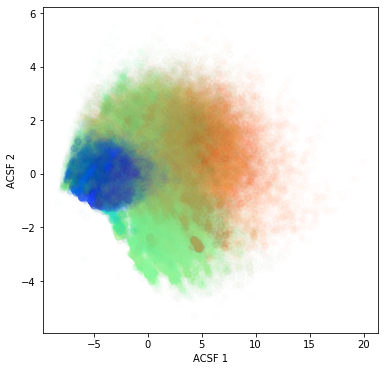

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha=0.01, c=w_spectra[:, 0], cmap="rainbow")

ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
plt.show()

#### Cluster 1 (Blue)

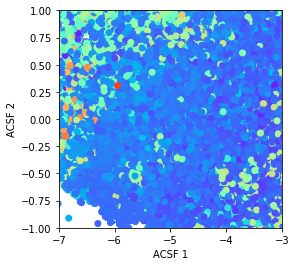

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha=1.0, c=w_spectra[:, 0], cmap="rainbow")

ax.set_xlim(-7,-3)
ax.set_ylim(-1,1)
ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
plt.show()

In [64]:
#Gathering points in region visually
indices = []
for i in range(len(w_acsf)):
    x,y = w_acsf[i]
    if -7<x<-3 and -1<y<1:
        indices.append(i)

In [65]:
blue = w_spectra[:,0][indices]
b_mean = np.mean(blue)
b_std = np.std(blue)

#spectra stats
print(b_mean, b_std)

-5.038981527865218 2.3511072985481447


In [66]:
#Getting points one std from mean spectra color
b_indices = []
for i in indices:
    if b_mean - b_std < w_spectra[:,0][i] < b_mean + b_std:
        b_indices.append(i)

#### Cluster 2 (Green)

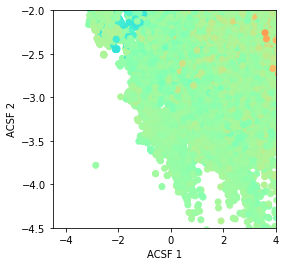

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha=1, c=w_spectra[:, 0], cmap="rainbow")

ax.set_xlim(-4.5,4)
ax.set_ylim(-4.5,-2)
ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
plt.show()

In [68]:
#Gathering points in region visually
indices = []
for i in range(len(w_acsf)):
    x,y = w_acsf[i]
    if -4.5<x<4 and -4.5<y<-2:
        indices.append(i)

In [69]:
green = w_spectra[:,0][indices]
g_mean = np.mean(green)
g_std = np.std(green)

#spectra stats
print(g_mean, g_std)

1.1168028342855034 0.6623179032008275


In [70]:
#Getting points one std from mean spectra color
g_indices = []
for i in indices:
    if g_mean - g_std < w_spectra[:,0][i] < g_mean + g_std:
        g_indices.append(i)

#### Cluster 3 (Orange)

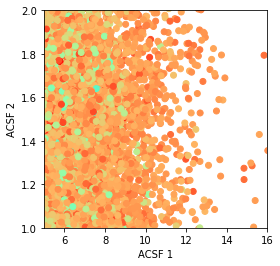

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(w_acsf[:, 0], w_acsf[:, 1], alpha=1, c=w_spectra[:, 0], cmap="rainbow")

ax.set_xlim(5,16)
ax.set_ylim(1,2)
ax.set_xlabel('ACSF 1')
ax.set_ylabel('ACSF 2')
plt.show()

In [72]:
#Gathering points in region visually
indices = []
for i in range(len(w_acsf)):
    x,y = w_acsf[i]
    if 5<x<16 and 1<y<2:
        indices.append(i)

In [73]:
orange = w_spectra[:,0][indices]
o_mean = np.mean(orange)
o_std = np.std(orange)

#spectra stats
print(o_mean, o_std)

4.584456810612885 1.2310724539354303


In [74]:
#Getting points one std from mean spectra color
o_indices = []
for i in indices:
    if o_mean - o_std < w_spectra[:,0][i] < o_mean + o_std:
        o_indices.append(i)

#### Load Oxygen SMILES Data

In [75]:
SMILES = data['origin_smiles']
SMILES = np.array(SMILES)

In [76]:
b_smiles = SMILES[b_indices]
o_smiles = SMILES[o_indices]
g_smiles = SMILES[g_indices]


In [77]:
print(b_indices[:10])
print(g_indices[:10])

[3, 5, 8, 12, 13, 15, 20, 23, 27, 28]
[6, 7, 10, 82, 98, 110, 123, 128, 132, 164]


#### Descriptor Information

In [78]:
#Convert SMILES to Mols
b_ms = [Chem.MolFromSmiles(smi) for smi in b_smiles]
o_ms = [Chem.MolFromSmiles(smi) for smi in o_smiles]
g_ms = [Chem.MolFromSmiles(smi) for smi in g_smiles]

In [79]:
printDescription("Blue", b_ms)
printDescription("Orange", o_ms)
printDescription("Green", g_ms)


                      ------Blue Group------

                     Mean                 SD
NumAtoms            = 8.8056            0.48382
NumBonds            = 9.1543            1.0539
Mol. Weight         = 123.52            7.0741
Num. Val. Electrons = 47.832            3.0945
Mol. Density        = 1.705            0.18764
                      ------Orange Group------

                     Mean                 SD
NumAtoms            = 8.9222            0.27688
NumBonds            = 9.901            0.75485
Mol. Weight         = 125.44            4.3907
Num. Val. Electrons = 50.41            1.9565
Mol. Density        = 1.5185            0.22582
                      ------Green Group------

                     Mean                 SD
NumAtoms            = 8.7811            0.53643
NumBonds            = 8.8641            1.0029
Mol. Weight         = 125.81            7.7409
Num. Val. Electrons = 50.583            3.3563
Mol. Density        = 1.6468            0.21922


In [80]:
names = data['names']
names = np.array(names)
b_names = names[b_indices]
o_names = names[o_indices]
g_names = names[g_indices]

In [81]:
#Add Hydrogen toms to the Mols
b_ms_H = [Chem.AddHs(mol) for mol in b_ms]
o_ms_H = [Chem.AddHs(mol) for mol in o_ms]
g_ms_H = [Chem.AddHs(mol) for mol in g_ms]

#Make list of absorbing atoms
b_abs_atom = [b_ms_H[i].GetAtomWithIdx(getIndex(b_names[i])) for i in range(len(b_ms_H))]
o_abs_atom = [o_ms_H[i].GetAtomWithIdx(getIndex(o_names[i])) for i in range(len(o_ms_H))]
g_abs_atom = [g_ms_H[i].GetAtomWithIdx(getIndex(g_names[i])) for i in range(len(g_ms_H))]

In [82]:
GetLocDesc("Blue", b_abs_atom)
GetLocDesc("Orange", o_abs_atom)
GetLocDesc("Green", g_abs_atom)


                      ------Blue Group------

Total:  39570

Neighbor Count 
(Neighbors of Absorbing Atom : Count / (Percentage)): 

['C'] :  38802  / (98.0591 %)
['N'] :  388  / (0.9805 %)
['N', 'C'] :  118  / (0.2982 %)
['C', 'N'] :  75  / (0.1895 %)
['C', 'C'] :  53  / (0.1339 %)
['N', 'H'] :  51  / (0.1289 %)
['C', 'C', 'H'] :  16  / (0.0404 %)
['O'] :  12  / (0.0303 %)
['C', 'H'] :  10  / (0.0253 %)
['C', 'C', 'H', 'H'] :  7  / (0.0177 %)
['C', 'N', 'H'] :  4  / (0.0101 %)
['O', 'C', 'H'] :  4  / (0.0101 %)
['C', 'O', 'H'] :  4  / (0.0101 %)
['C', 'O'] :  4  / (0.0101 %)
['N', 'C', 'H'] :  3  / (0.0076 %)
['C', 'H', 'H', 'H'] :  2  / (0.0051 %)
['O', 'N', 'H'] :  2  / (0.0051 %)
['C', 'C', 'N'] :  2  / (0.0051 %)
['C', 'O', 'O'] :  2  / (0.0051 %)
['N', 'C', 'H', 'H'] :  1  / (0.0025 %)
['C', 'N', 'N'] :  1  / (0.0025 %)
['O', 'C'] :  1  / (0.0025 %)
['O', 'O', 'C'] :  1  / (0.0025 %)
['N', 'O'] :  1  / (0.0025 %)
['C', 'C', 'N', 'H'] :  1  / (0.0025 %)
['N', 'N', 'H'] :  1  / (0.

#### Drawing Molecules From Groups (Oxygen)

In [83]:
b_hl_list = GetNeighborIdx(b_ms_H, b_names)
o_hl_list = GetNeighborIdx(o_ms_H, o_names)
g_hl_list = GetNeighborIdx(g_ms_H, g_names)

In [84]:
b_labels = [b_names[i] + " (Blue)" for i in range(len(b_names))]
o_labels = [o_names[i] + " (Orange)" for i in range(len(o_names))]
g_labels = [g_names[i] + " (Green)" for i in range(len(g_names))]

In [85]:
h_b_ms_H = b_ms_H
h_o_ms_H = o_ms_H
h_g_ms_H = g_ms_H

for i in range(len(b_ms_H)):
    h_b_ms_H[i].__sssAtoms = b_hl_list[i]

for i in range(len(o_ms_H)):
    h_o_ms_H[i].__sssAtoms = o_hl_list[i]

for i in range(len(g_ms_H)):
    h_g_ms_H[i].__sssAtoms = g_hl_list[i]

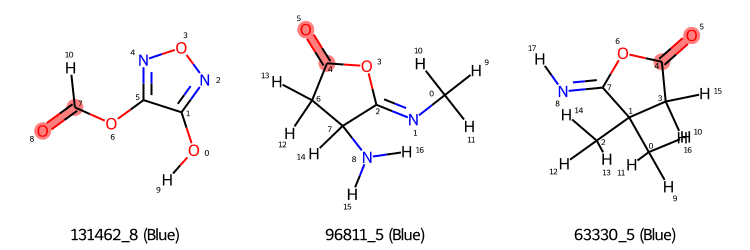

In [86]:
img5 = Draw.MolsToGridImage(h_b_ms_H[:3], subImgSize=(250,250), highlightAtomLists=b_hl_list, useSVG = True, legends = b_labels[:3])
img5

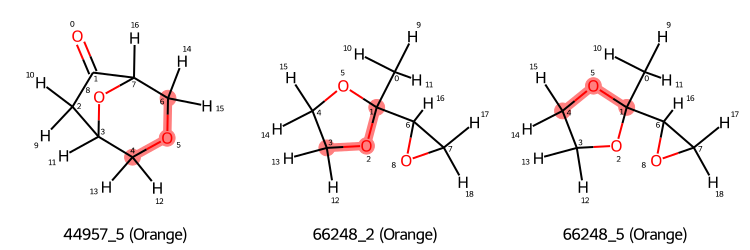

In [87]:
img6 = Draw.MolsToGridImage(h_o_ms_H[:3], subImgSize=(250,250), highlightAtomLists=o_hl_list, useSVG = True, legends = o_labels[:3])
img6

In [88]:
img7 = Draw.MolsToGridImage(h_g_ms_H[:3], subImgSize=(250,250), highlightAtomLists=g_hl_list, useSVG = True, legends = g_labels[:3])
img7